## Setup environment

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.networks.nets import resnet50
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

from pathlib import Path

import torchvision

import pickle

print_config()



MONAI version: 1.1.dev2245
Numpy version: 1.23.4
Pytorch version: 1.10.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2bfea77190b49e277c239bcf77076b8fb40a7ee2
MONAI __file__: c:\Users\CAI-Alienware2\anaconda3\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2+cu113
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please v

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
#from google.colab import drive 

#drive.mount("content")

In [3]:
#directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
#print(root_dir)

## Dataset

In [4]:
#resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
#md5 = "0bc7306e7427e00ad1c5526a6677552d"

#compressed_file = os.path.join(root_path, "MedNIST.tar.gz")

#if not os.path.exists(data_dir):
    #download_and_extract(resource, compressed_file, root_path, md5)

In [5]:
root_path = Path("Split/train")
root_val = Path("Split/val")
root_test = Path("Split/test")

data_dir = os.path.join(root_path)
data_val = os.path.join(root_val)
data_test = os.path.join(root_test)

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=5)

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Read image filenames from the dataset folders


In [8]:
class_names_val = sorted(x for x in os.listdir(data_val)
                     if os.path.isdir(os.path.join(data_val, x)))
num_class_val = len(class_names_val)
image_files_val = [
    [
        os.path.join(data_val, class_names_val[i], x)
        for x in os.listdir(os.path.join(data_val, class_names_val[i]))
    ]
    for i in range(num_class_val)
]
num_each = [len(image_files_val[i]) for i in range(num_class_val)]
image_files_list_val = []
image_class_val = []
for i in range(num_class_val):
    image_files_list_val.extend(image_files_val[i])
    image_class_val.extend([i] * num_each[i])
num_total = len(image_class_val)
image_width, image_height = PIL.Image.open(image_files_list_val[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names_val}")
print(f"Label counts: {num_each}")

Total image count: 96
Image dimensions: 224 x 224
Label names: ['0', '1']
Label counts: [57, 39]


In [9]:
class_names_test = sorted(x for x in os.listdir(data_test)
                     if os.path.isdir(os.path.join(data_test, x)))
num_class_test = len(class_names_test)
image_files_test = [
    [
        os.path.join(data_test, class_names_test[i], x)
        for x in os.listdir(os.path.join(data_test, class_names_test[i]))
    ]
    for i in range(num_class_test)
]
num_each = [len(image_files_test[i]) for i in range(num_class_test)]
image_files_list_test = []
image_class_test = []
for i in range(num_class_test):
    image_files_list_test.extend(image_files_test[i])
    image_class_test.extend([i] * num_each[i])
num_total = len(image_class_test)
image_width, image_height = PIL.Image.open(image_files_list_test[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names_test}")
print(f"Label counts: {num_each}")

Total image count: 61
Image dimensions: 224 x 224
Label names: ['0', '1']
Label counts: [34, 27]


In [10]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 461
Image dimensions: 224 x 224
Label names: ['0', '1']
Label counts: [246, 215]


## Randomly pick images from the dataset to visualize and check

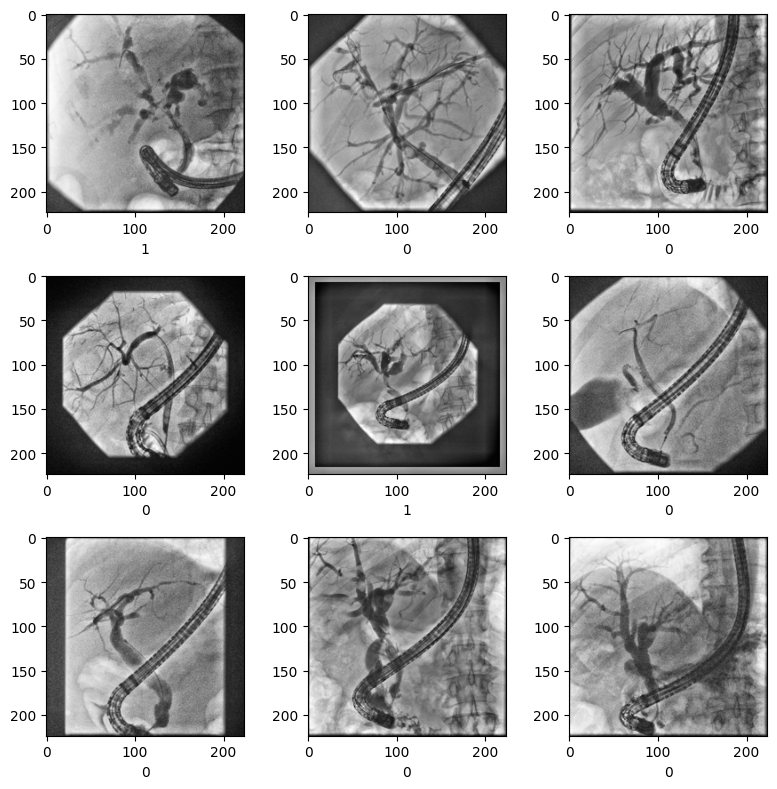

In [11]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists


In [12]:
val_frac = 0.0
test_frac = 0.0
length = len(image_files_list)

length_val = (len(image_files_list_val))
length_test = (len(image_files_list_test))

indices = np.arange(length)
indices_val = np.arange(length_val)
indices_test = np.arange(length_test)

np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
#val_indices = indices_val[-2:2]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list_val[i] for i in indices_val]
val_y = [image_class_val[i] for i in indices_val]
test_x = [image_files_list_test[i] for i in indices_test]
test_y = [image_class_test[i] for i in indices_test]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 461, Validation count: 96, Test count: 61


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [13]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=1.0, contrast=0.25)
    
#crop= torchvision.transforms.CenterCrop(380)

In [14]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 10, prob=0.8, keep_size=True),
        #RandFlip(spatial_axis=0, prob=0.5),
        #RandZoom(min_zoom=0.7, max_zoom=1.3, prob=0.8),
        color_aug,
        RandZoom(min_zoom=1.4, max_zoom=1.7, prob=1.0)
        #crop,
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity(), RandZoom(min_zoom=1.6, max_zoom=1.6, prob=1.0)])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [15]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=0)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=10, num_workers=0)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=10, num_workers=0)

#for i in range (373):
 #   print(train_ds[i][0].shape)
  #  print(i)

#for i in range (70):
 #   print(val_ds[i][0].shape)
  #  print(i)

#print(val_ds[24])

## Define network and optimizer

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=2).to(device)
                    
#pretrained='densenet.hdf5'



loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 1000
val_interval = 1
auc_metric = ROCAUCMetric()
print(device)
torch.cuda.is_available()

cuda


True

## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [17]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
early_stopping = EarlyStopping(patience=100, verbose=True)
val_loss_values = []


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epochlossv=0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            outputsv = model(val_images)
            lossv = loss_function(outputsv, val_labels)
            epochlossv += lossv.item()

            val_loss_values.append(epochlossv)

            print(f"val_loss: {epochlossv}")

            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)


            torch.save(model.state_dict(), os.path.join(
                    root_path, f"best_metric_model" + str(epoch+1) +".pth"))
            if (epoch+1) == max_epochs:
                torch.save(model.state_dict(), os.path.join(
                    root_path, f"best_metric_model" + str(epoch+1) +".pth"))
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_path, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    early_stopping(epochlossv, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        #break

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/1000
1/7, train_loss: 0.7001
2/7, train_loss: 0.7088
3/7, train_loss: 0.7109
4/7, train_loss: 0.7052
5/7, train_loss: 0.7048
6/7, train_loss: 0.7009
7/7, train_loss: 0.7038
8/7, train_loss: 0.7412
epoch 1 average loss: 0.7095
val_loss: 0.7500690817832947
saved new best metric model
current epoch: 1 current AUC: 0.5578 current accuracy: 0.5938 best AUC: 0.5578 at epoch: 1
Validation loss decreased (inf --> 0.750069).  Saving model ...
----------
epoch 2/1000
1/7, train_loss: 0.7158
2/7, train_loss: 0.6857
3/7, train_loss: 0.6918
4/7, train_loss: 0.7063
5/7, train_loss: 0.6790
6/7, train_loss: 0.6872
7/7, train_loss: 0.7303
8/7, train_loss: 0.7291
epoch 2 average loss: 0.7032
val_loss: 0.7040649056434631
current epoch: 2 current AUC: 0.4638 current accuracy: 0.5104 best AUC: 0.5578 at epoch: 1
Validation loss decreased (0.750069 --> 0.704065).  Saving model ...
----------
epoch 3/1000
1/7, train_loss: 0.7140
2/7, train_loss: 0.6893
3/7, train_loss: 0.6892
4/7, train_lo

KeyboardInterrupt: 

## Plot the loss and metric

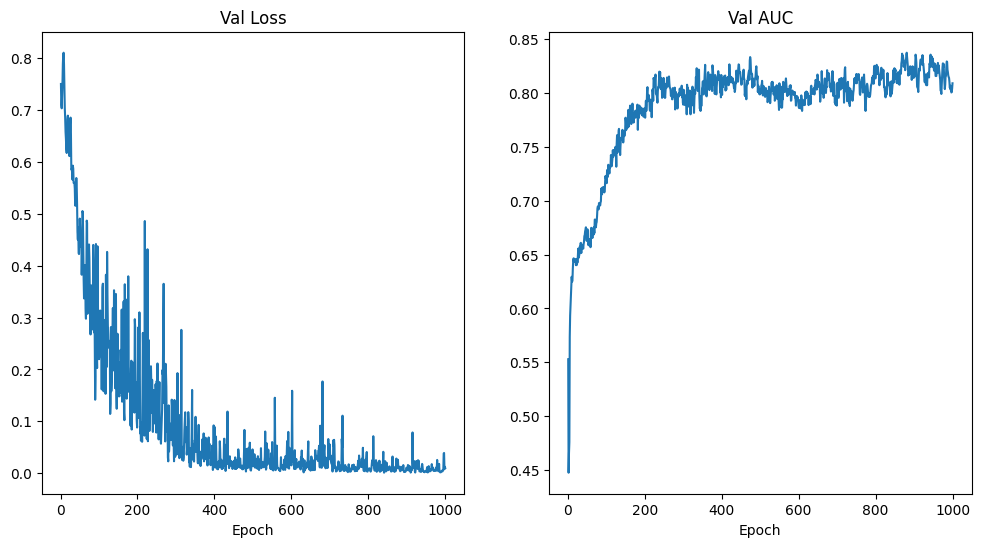

In [ ]:
plt.figure("val", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Val Loss")
x = [i + 1 for i in range(len(val_loss_values))]
y = val_loss_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.savefig("val_loss.png")
plt.show()

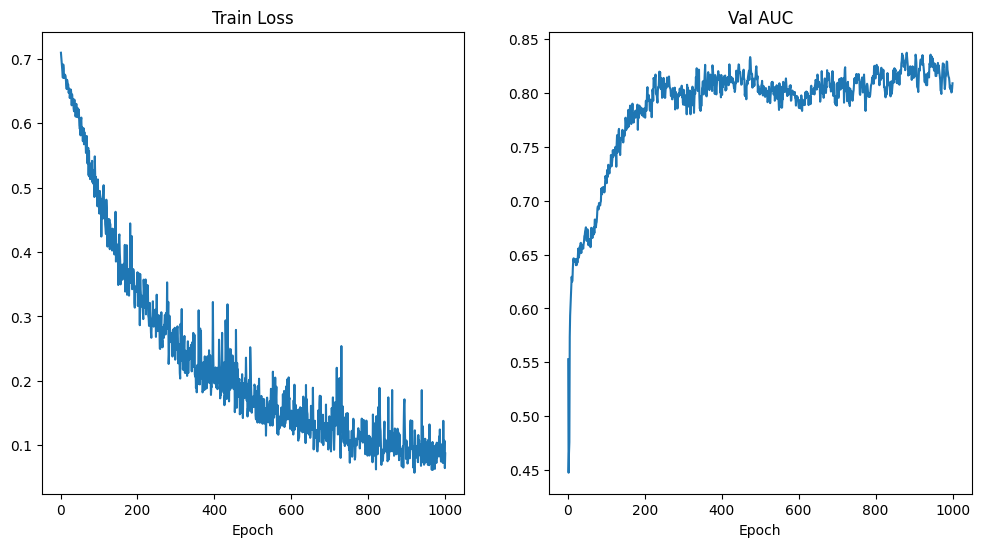

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.savefig("train_loss.png")
plt.show()

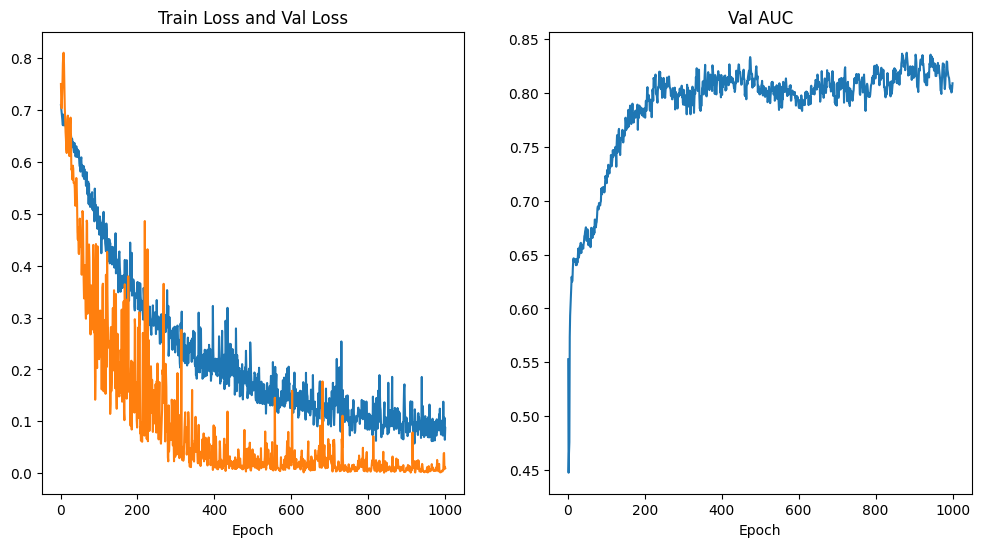

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train Loss and Val Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
y2 = val_loss_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.plot(x, y2)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.savefig("val_loss_train_loss2.png")
plt.show()

In [ ]:
##Save


with open("train_loss", "wb") as fp:   #Pickling
    pickle.dump(epoch_loss_values, fp)

with open("val_loss", "wb") as fp:   #Pickling
    pickle.dump(val_loss_values, fp)

with open("metric_values", "wb") as fp:   #Pickling
    pickle.dump(metric_values, fp)


In [ ]:
##Load

with open("train_loss", "rb") as fp:   # Unpickling
    epoch_loss_values = pickle.load(fp)

with open("val_loss", "rb") as fp:   # Unpickling
    val_loss_values = pickle.load(fp)

with open("metric_values", "rb") as fp:   # Unpickling
    metric_values = pickle.load(fp)

## Evaluate the model on test dataset


In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_path, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
bild_test = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        #bild_test.extend(test_images)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(y_true)
print(y_pred)

print(test_images.shape)
bild_test.extend(test_images)
bild_test=test_images
print(bild_test.shape)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
(1, 1, 224, 224)
(1, 1, 224, 224)


In [ ]:
print(classification_report(
    y_true, y_pred, target_names=class_names_test, digits=4))

              precision    recall  f1-score   support

           0     0.7333    0.9706    0.8354        34
           1     0.9375    0.5556    0.6977        27

    accuracy                         0.7869        61
   macro avg     0.8354    0.7631    0.7666        61
weighted avg     0.8237    0.7869    0.7745        61

